In [2]:

import pickle
import time
import logging
import numpy as np
import extra_data as ed
from copy import copy
import os
from scipy import optimize
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks




from scipy import special

from sklearn.decomposition import PCA

import cv2

import matplotlib.pyplot as plt
from skimage import transform

import matplotlib.style
import matplotlib as mpl
mpl.style.use('./newClassic.mplstyle')

%config InlineBackend.figure_format='retina'


Bad key figure.labelsize in file ./newClassic.mplstyle, line 312 ('figure.labelsize:   18    # size of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key figure.labelweight in file ./newClassic.mplstyle, line 313 ('figure.labelweight: normal    # weight of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
def extraVISARImages_mean(exp_id, run_id):
    # exp_id = 900352  # Commisioning experiment
    # run_id = 184  # Streak camera calibration image run

    # Import run data and display info on run
    run = ed.open_run(exp_id, run_id)
    # run.info()
    # Determine first and last train ids
    first_train = run.train_ids[0]
    last_train = run.train_ids[-1]
    # print(f"First train ID: {first_train}")
    # print(f"Last train ID: {last_train}")

    # Create a mask for pandas df where no data exists
    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present:\n{indexes}")

    # # Select train ID for streak calibration
    # train_id = 1605832127
    # print(f'\nSelecting Train ID: {train_id}')

    # Raw data from streak camera image
    kep1 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )


    imgKEP1_r = np.mean(kep1[:, :, :], axis = 0)
    # Rotate image 90 degrees
    imgKEP1_r = cv2.rotate(imgKEP1_r, cv2.ROTATE_90_COUNTERCLOCKWISE)
    f = np.loadtxt('../VISAR_DewarpingCalibration/VISAR_KEPLER1_20nsWindow_p2740_run639_evt1_polynomial.cal', delimiter=',')
    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]


    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")
    

    imgKEP1_r_dewarp = cv2.remap(
        imgKEP1_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )

    imgKEP1_r_dewarp = np.fliplr(imgKEP1_r_dewarp)
    
    

    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present")


    kep2 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )

    imgKEP2_r = np.mean(kep2, axis = 0)
    imgKEP2_r = cv2.rotate(imgKEP2_r, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    
    # f = np.loadtxt('../../VISAR_CalibrationFiles_latest/VISAR_KEPLER2_20nsWindow_p2740_run26_evt1_V2.cal', delimiter=',')
    # f = np.loadtxt('../VISAR_CalibrationFiles_latest/VISAR_KEPLER2_20nsWindow_p2740_run1222_evt1_polynomial.cal', delimiter=',')
    f = np.loadtxt('../VISAR_DewarpingCalibration/VISAR_KEPLER2_20nsWindow_p2740_run1222_evt1_polynomial_AdditionalPointForXrayFiducial.cal', delimiter=',')

    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]


    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")
    

    imgKEP2_r_dewarp = cv2.remap(
        imgKEP2_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    
    imgKEP2_r_dewarp = np.fliplr(imgKEP2_r_dewarp)


    # Create a mask for pandas df where no data exists
    mask = run['HED_EXP_VISAR/EXP/ARM_3_STREAK:daqOutput', 'data.image.pixels'].data_counts() != 0
    
    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero()+first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f'{indexes_count} Train IDs with data present:\n{indexes}')
    
    # # Select train ID for streak calibration
    # train_id = 1605832127
    # print(f'\nSelecting Train ID: {train_id}')
    
    # Raw data from streak camera image
    Vis_1w = run['HED_EXP_VISAR/EXP/ARM_3_STREAK:daqOutput']['data.image.pixels'].select_trains(ed.by_id[np.squeeze(indexes)]).ndarray()
    
    # img = np.sum(kep1, axis = 0).copy()
    img_Vis_1w = np.mean(Vis_1w, axis = 0).copy()
    # img = np.copy(Vis_1w[4, :, :])
    
    img_Vis_1w = cv2.rotate(cv2.resize(img_Vis_1w,
                                         (img_Vis_1w.shape[0]*2, img_Vis_1w.shape[1]*2),
                                          interpolation=cv2.INTER_CUBIC),
                                          cv2.ROTATE_90_COUNTERCLOCKWISE)
    # # Rotate image 90 degrees
    # img_Vis_1w = rotate(img_Vis_1w,90,preserve_range=True)
    
    
    return imgKEP1_r_dewarp, imgKEP2_r_dewarp, img_Vis_1w

In [4]:
def extraVISARImages(exp_id, run_id):
    # exp_id = 900352  # Commisioning experiment
    # run_id = 184  # Streak camera calibration image run

    # Import run data and display info on run
    run = ed.open_run(exp_id, run_id)
    # run.info()
    # Determine first and last train ids
    first_train = run.train_ids[0]
    last_train = run.train_ids[-1]
    # print(f"First train ID: {first_train}")
    # print(f"Last train ID: {last_train}")

    # Create a mask for pandas df where no data exists
    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present:\n{indexes}")

    # # Select train ID for streak calibration
    # train_id = 1605832127
    # print(f'\nSelecting Train ID: {train_id}')

    # Raw data from streak camera image
    kep1 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )
    
    f = np.loadtxt('../VISAR_DewarpingCalibration/VISAR_KEPLER1_20nsWindow_p2740_run639_evt1_polynomial.cal', delimiter=',')
    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]
    
    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")

        

    imgKEP1_dewarp = []
    
    for i in range(kep1.shape[0]):
        imgKEP1_r = np.copy(kep1[i, :, :])
        # Rotate image 90 degrees
        imgKEP1_r = cv2.rotate(imgKEP1_r, cv2.ROTATE_90_COUNTERCLOCKWISE)

        imgKEP1_r_dewarp = cv2.remap(
            imgKEP1_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
        )
        imgKEP1_dewarp += [np.fliplr(imgKEP1_r_dewarp)]

    
    
    

    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present")


    kep2 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )

    
    # f = np.loadtxt('../../VISAR_CalibrationFiles_latest/VISAR_KEPLER2_20nsWindow_p2740_run26_evt1_V2.cal', delimiter=',')
    f = np.loadtxt('../VISAR_DewarpingCalibration/VISAR_KEPLER2_20nsWindow_p2740_run1222_evt1_polynomial_AdditionalPointForXrayFiducial.cal', delimiter=',')
    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]


    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")
    
    
    imgKEP2_dewarp = []
    
    for i in range(kep2.shape[0]):
        imgKEP2_r = np.copy(kep2[i, :, :])
        imgKEP2_r = cv2.rotate(imgKEP2_r, cv2.ROTATE_90_COUNTERCLOCKWISE)


        imgKEP2_r_dewarp = cv2.remap(
            imgKEP2_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
        )
        imgKEP2_dewarp += [np.fliplr(imgKEP2_r_dewarp)]


        
    return np.array(imgKEP1_dewarp), np.array(imgKEP2_dewarp), img_Vis_1w

In [5]:
imgKEP1_r, imgKEP2_r, img_1wVis_r  = extraVISARImages_mean(6656, 82)

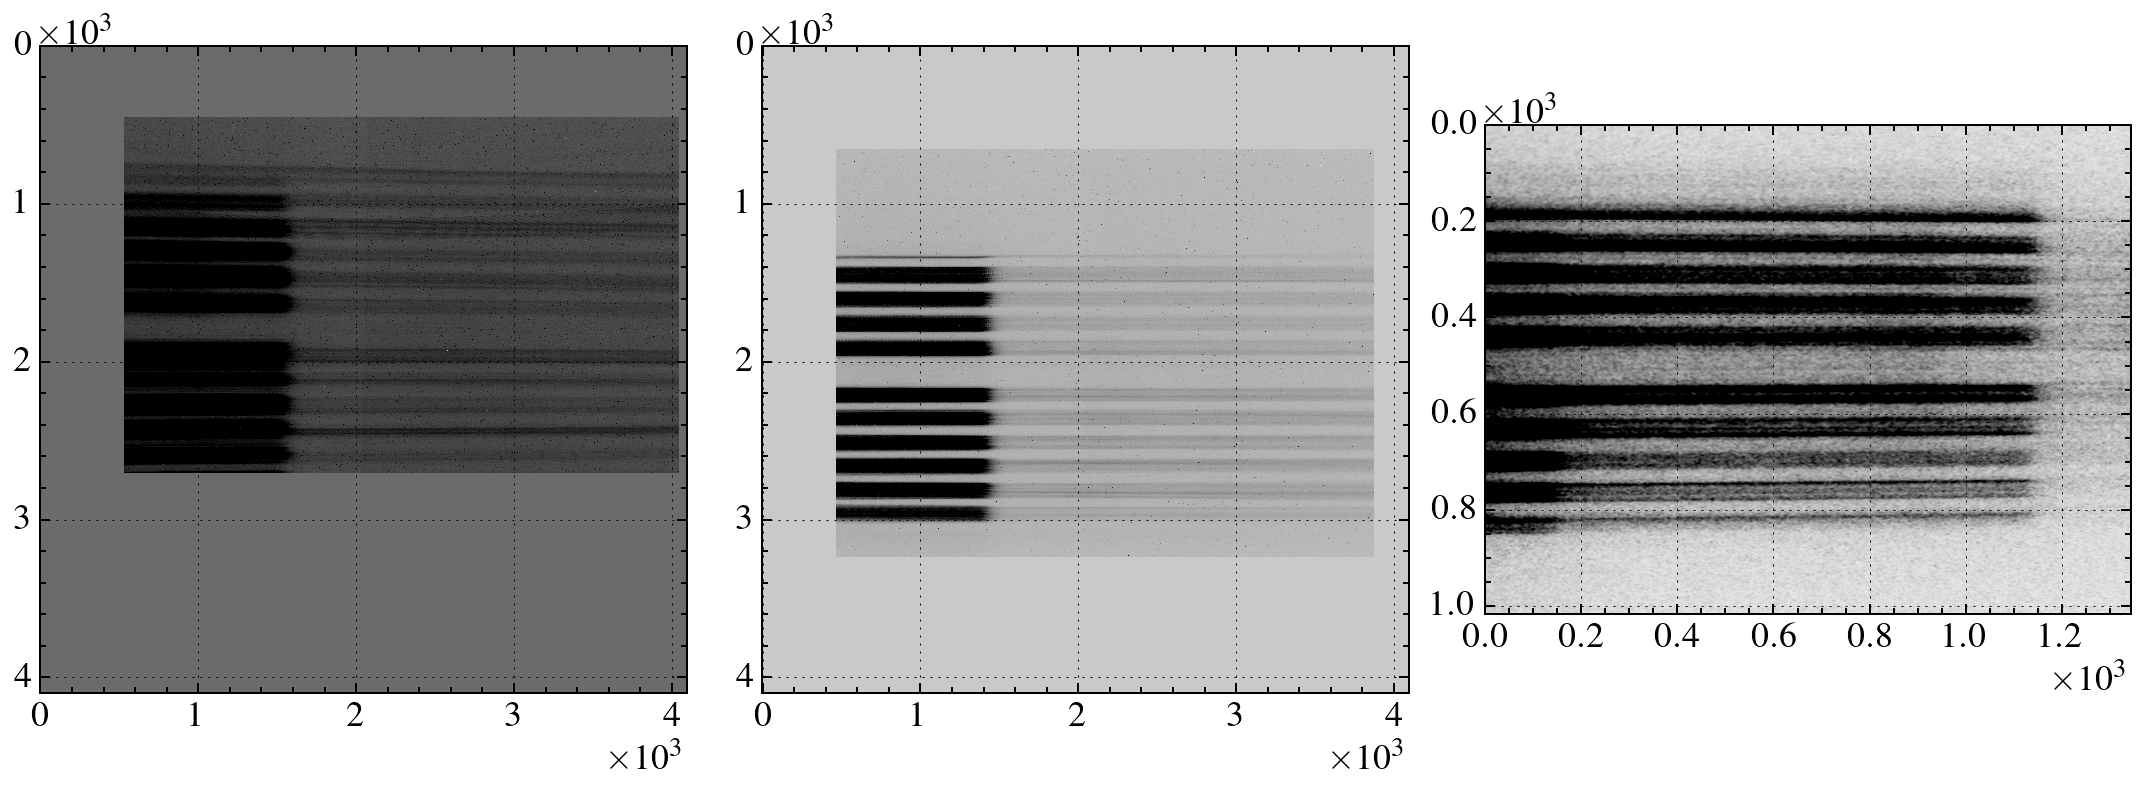

In [6]:
plt.figure(figsize = (15, 10))
plt.subplot(131)
plt.imshow(imgKEP1_r, vmin = 0, vmax = 200, cmap = plt.cm.binary)

plt.subplot(132)
plt.imshow(imgKEP2_r, vmin = 0, vmax = 500, cmap = plt.cm.binary)

plt.subplot(133)
plt.imshow(img_1wVis_r, vmin = 0, vmax = 5000, cmap = plt.cm.binary)

# plt.hlines(3000, 0, 4095, color = 'w')
# plt.hlines(3200, 0, 4095, color = 'w')
# plt.colorbar()
plt.tight_layout()
plt.show()

In [7]:
img_1wVis_r.shape, np.arange(0, img_1wVis_r.shape[0], 1).shape

((1016, 1344), (1016,))

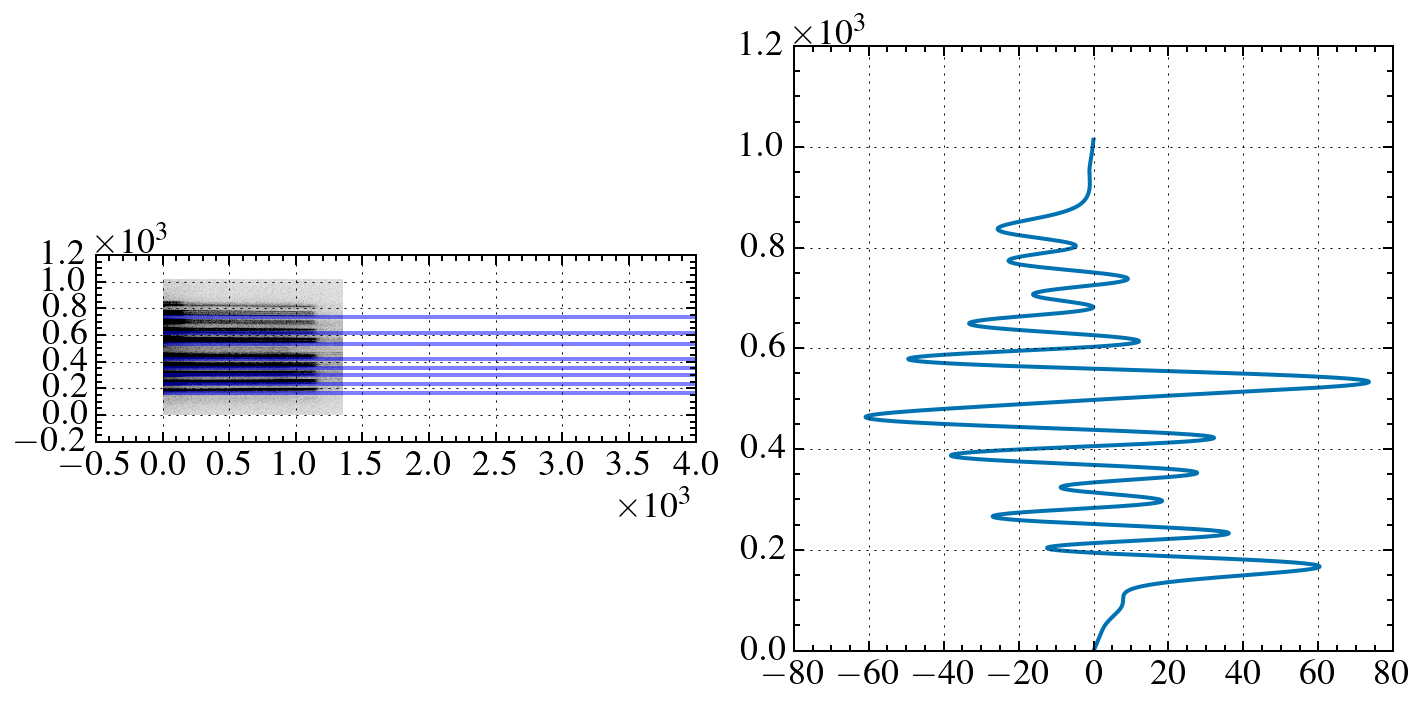

In [44]:
lineout = np.mean(img_1wVis_r[:, 500:1000], axis = 1)
lineoutFilter = gaussian_filter1d(lineout, 20)
peaks, _ = find_peaks(np.diff(lineoutFilter), distance = 40, height = 1)

plt.figure(figsize = (10, 5))
plt.subplot(121)
# plt.pcolormesh(np.arange(0, img_1wVis_r.shape[0], 1), np.arange(0, img_1wVis_r.shape[1], 1), img_1wVis_r, vmin = 0, vmax = 5000, cmap = plt.cm.binary)
plt.imshow(img_1wVis_r, vmin = 0, vmax = 5000, cmap = plt.cm.binary)

plt.hlines(peaks, 0, 4000, alpha = 0.5)
# plt.hlines(peaks, 0, imgKEP2_r.shape[0], alpha = 0.5, color = 'w')
plt.gca().invert_yaxis()
# plt.xlabel('Pix')
# plt.ylabel('Pix')
# plt.xlim([0, 4000])
# plt.ylim([0, 4000])

plt.subplot(122)
# # plt.plot(np.mean(imgKEP2_r[:, 500:1000], axis = 1))

# plt.plot(lineout, np.arange(0, imgKEP2_r.shape[0], 1))
# plt.plot(lineoutFilter, np.arange(0, imgKEP1_r.shape[0], 1))
# plt.hlines(peaks, 0, 1000, alpha = 0.5)
# plt.ylim([0, 4000])
# plt.xlim([0, 1000])
# plt.ylim([1000, 3200])
# plt.subplot(133)

plt.plot(np.diff(lineoutFilter), np.arange(0, img_1wVis_r.shape[0]-1, 1))
# plt.plot(peaks, np.diff(lineoutFilter)[peaks], '.')

# plt.subplot(133)
# plt.plot(np.mean(img_1wVis_r[:, 400:800], axis = 1))

plt.tight_layout()
# plt.savefig('./SpatialCalibration_KEP2_1.pdf')
plt.show()

In [45]:
np.diff(peaks[:])

array([ 66,  64,  56,  69, 111,  81, 124])

In [46]:
tt = np.array([66,  64,  56,  69, 56, 56])
np.mean(tt), np.std(tt)

(61.166666666666664, 5.367080729368206)

# 

In [48]:
np.sum(np.diff(peaks[1:]))/(9+1) # 9+1 because there is missing one line in the center

62.6

In [17]:
run = ed.open_run(6656, 87)
VISAR_Alignment_CAM_ref = run['HED_EXP_VISAR/CAM/ARM_1_INTERF:daqOutput', 'data.image.pixels'].ndarray()
VISAR_Alignment_CAM_ref = np.mean(VISAR_Alignment_CAM_ref, axis = 0)

In [18]:
run = ed.open_run(6656, 82)
VISAR_Alignment_CAM = run['HED_EXP_VISAR/CAM/ARM_2_INTERF:daqOutput', 'data.image.pixels'].ndarray()
# VISAR_Alignment_CAM = np.mean(VISAR_Alignment_CAM, axis = 0)

In [37]:
# run = ed.open_run(6656, 82)
run = ed.open_run(900455, 77)
VISAR_Alignment_CAM_r77 = run['HED_EXP_VISAR/CAM/ARM_2_INTERF:daqOutput', 'data.image.pixels'].ndarray()

run = ed.open_run(900455, 123)
VISAR_Alignment_CAM_r78 = run['HED_EXP_VISAR/CAM/ARM_2_INTERF:daqOutput', 'data.image.pixels'].ndarray()
# VISAR_Alignment_CAM = np.mean(VISAR_Alignment_CAM, axis = 0)

In [38]:
# # run.info()
# VISAR_Alignment_CAM.shape

In [39]:
testContrast = np.copy(VISAR_Alignment_CAM[0, :, :].T)
testContrast = (testContrast-np.min(testContrast))/np.max(testContrast)
testContrast = np.exp(3*(testContrast-np.mean(testContrast)))

[39 22 20 20 20 22 20 20 20 44 20 20 22 20 20 20 21 21]
[ 90  80  65  77  79 108  91]


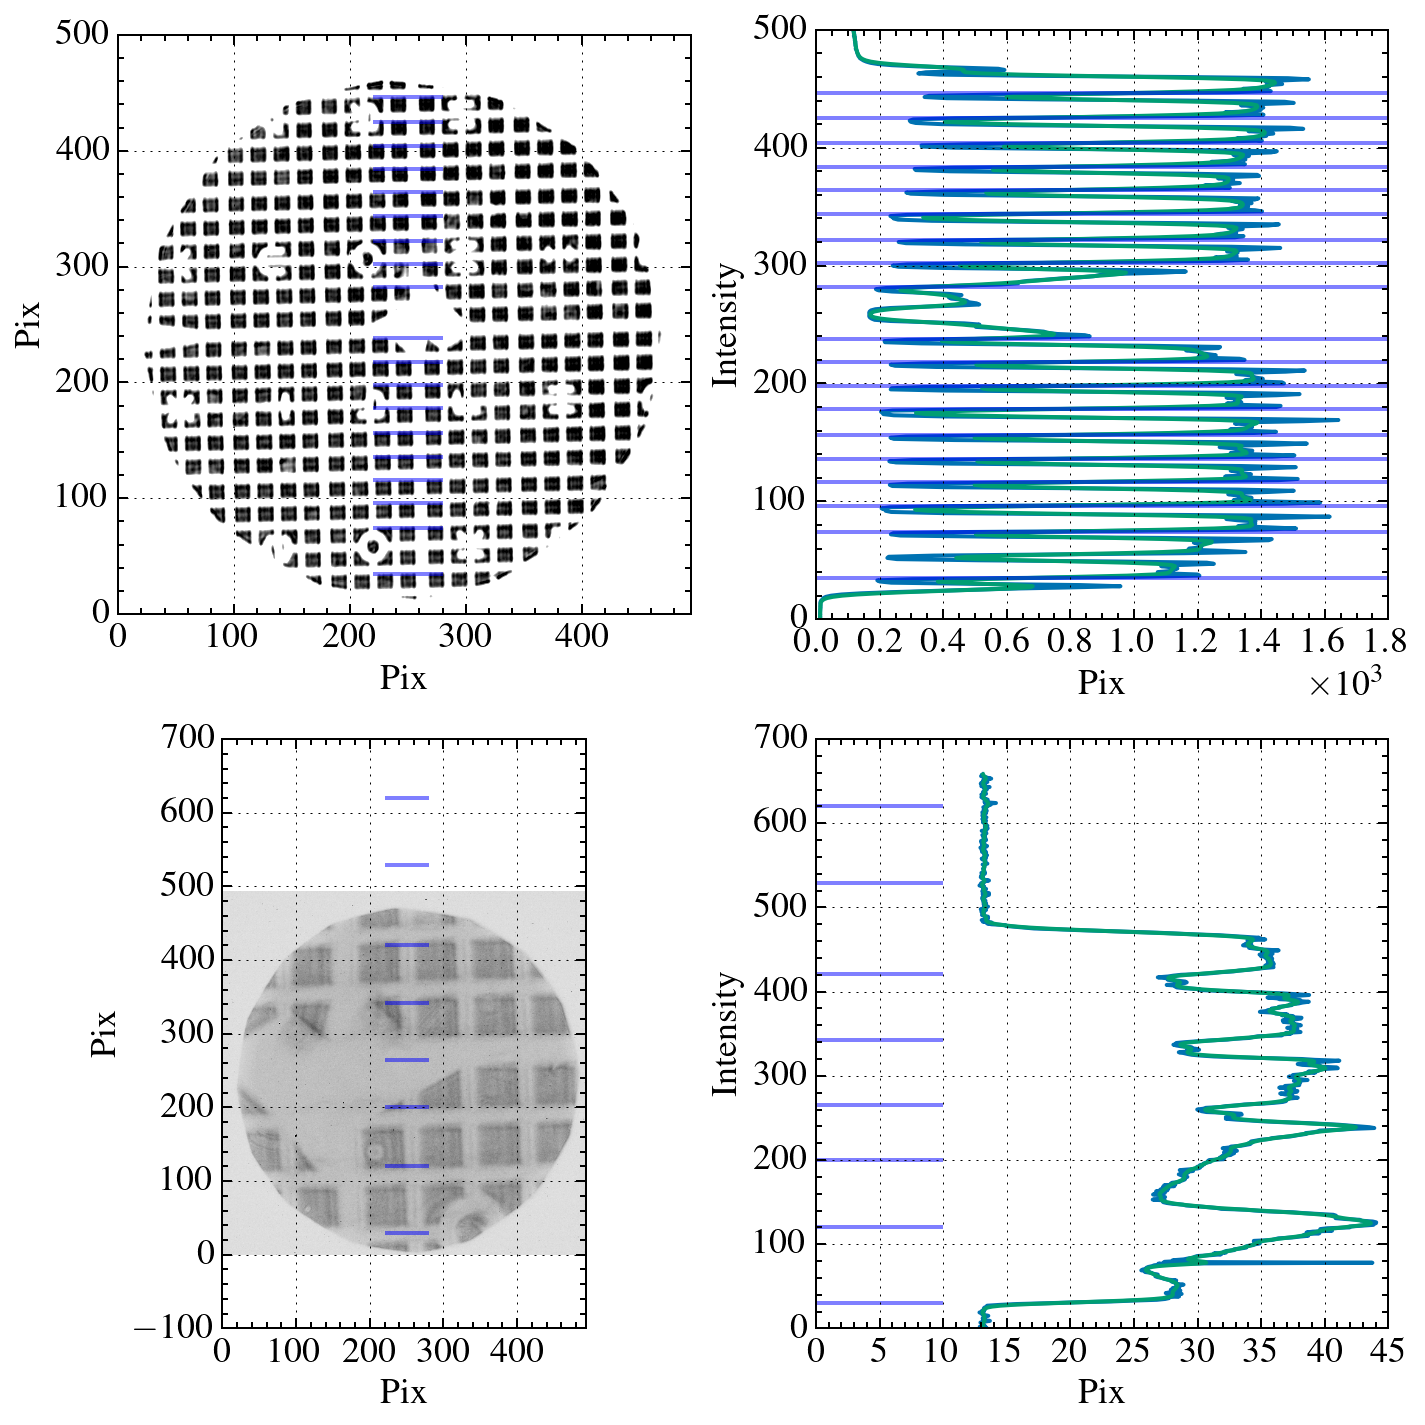

In [42]:
lineout = np.mean(VISAR_Alignment_CAM_r77[0, 220:280, :], axis = 0)
lineoutFilter = gaussian_filter1d(lineout, 2)
peaks, _ = find_peaks(np.diff(lineoutFilter), distance = 20, height = 10)

# lineout = np.mean(VISAR_Alignment_CAM_r77[0, 220:280, :], axis = 0)
# lineoutFilter = gaussian_filter1d(lineout, 2)
# peaks, _ = find_peaks(np.diff(lineoutFilter), distance = 20, height = 10)

plt.figure(figsize = (10, 10))

plt.subplot(221)
plt.imshow(VISAR_Alignment_CAM_r77[0, :, :], vmin = 1000, vmax = 2000, cmap = plt.cm.binary)
# plt.imshow(testContrast, cmap = plt.cm.binary)
# plt.colorbar()
plt.hlines(peaks[:], 220, 280, alpha = 0.5, color = 'b')
plt.gca().invert_yaxis()
plt.xlabel('Pix')
plt.ylabel('Pix')
plt.xlim([0, VISAR_Alignment_CAM_r77.shape[1]])
# plt.ylim([0, VISAR_Alignment_CAM.shape[2]])
plt.ylim([0, 500])
print(np.diff(peaks))

plt.subplot(222)

plt.plot(lineout, np.arange(0, VISAR_Alignment_CAM_r77.shape[2], 1))
plt.plot(lineoutFilter, np.arange(0, VISAR_Alignment_CAM_r77.shape[2], 1))
plt.hlines(peaks, 0, 1800, alpha = 0.5)
# print(np.sum(np.diff(peaks)[1:])/18)


# ax2 = ax1.twiny()
# plt.plot(np.diff(lineoutFilter), np.arange(0, VISAR_Alignment_CAM.shape[2], 1)[1:])
# plt.plot(np.diff(lineoutFilter)[peaks], peaks, '.')


plt.xlabel('Pix')
plt.ylabel('Intensity')
# plt.ylim([0, VISAR_Alignment_CAM.shape[2]])
plt.ylim([0, 500])

lineout = np.mean(VISAR_Alignment_CAM_r78[0, 280:320, :], axis = 0)
lineoutFilter = gaussian_filter1d(lineout, 2)
peaks, _ = find_peaks(np.diff(lineoutFilter), distance = 50, height = 0)
# print(np.sum(np.diff(peaks)[:10])/10)


plt.subplot(223)
plt.imshow(VISAR_Alignment_CAM_r78[0, :, :], vmin =0, vmax = 100, cmap = plt.cm.binary)
# plt.imshow(testContrast, cmap = plt.cm.binary)
# plt.colorbar()
plt.hlines(peaks[:], 220, 280, alpha = 0.5, color = 'b')
plt.gca().invert_yaxis()
plt.xlabel('Pix')
plt.ylabel('Pix')
plt.xlim([0, VISAR_Alignment_CAM_r78.shape[1]])
# plt.ylim([0, VISAR_Alignment_CAM.shape[2]])
# plt.ylim([0, 500])

plt.subplot(224)
print(np.diff(peaks))
plt.plot(lineout, np.arange(0, VISAR_Alignment_CAM_r78.shape[2], 1))
plt.plot(lineoutFilter, np.arange(0, VISAR_Alignment_CAM_r78.shape[2], 1))
plt.hlines(peaks, 0, 10, alpha = 0.5)

# ax2 = ax1.twiny()
# plt.plot(np.diff(lineoutFilter), np.arange(0, VISAR_Alignment_CAM.shape[2], 1)[1:])
# plt.plot(np.diff(lineoutFilter)[peaks], peaks, '.')


plt.xlabel('Pix')
plt.ylabel('Intensity')
# plt.ylim([0, VISAR_Alignment_CAM.shape[2]])
# plt.ylim([0, 500])

# plt.subplot(133)

# plt.plot(np.diff(lineoutFilter))
# plt.plot(peaks, np.diff(lineoutFilter)[peaks], '.')
# plt.xlabel('Pix')
# plt.hlines(3000, 0, 4095, color = 'w')
# plt.hlines(3200, 0, 4095, color = 'w')
# plt.colorbar()
plt.tight_layout()
# plt.savefig('./SpatialCalibration_VISARAlignmentCamera_TCC_2.pdf')
plt.show()

In [43]:
ttt = np.array([22, 20, 20, 20, 22, 20, 20, 20, 22, 22, 20, 20, 22, 20, 20, 20, 21, 21])
np.mean(ttt), np.std(ttt)

(20.666666666666668, 0.8819171036881969)

In [ ]:
# np.diff(peaks[1:])